In [1]:
import pykitti
import b3d
import os
import jax.numpy as jnp
from tqdm import tqdm
import genjax
from b3d import Mesh, Pose
import rerun as rr
import jax
from genjax import Pytree
import matplotlib.pyplot as plt

kitti_data_path = b3d.get_assets_path() / "shared_data_bucket/foundation_pose_tracking_datasets/kitti_initial_data.npz"
data = jnp.load(kitti_data_path)
rgbd = jnp.concatenate([data["rgb"], data["depths"][...,None]], axis=-1)
key = jax.random.PRNGKey(0)

image_height, image_width = data["rgb"][0].shape[:2]
fx,fy,cx,cy,near,far = data["camera_intrinsics"]
scaling_factor = 0.3
renderer = b3d.renderer.renderer_original.RendererOriginal(
    image_width * scaling_factor, image_height * scaling_factor, fx * scaling_factor, fy * scaling_factor, cx * scaling_factor, cy * scaling_factor, 0.01, 2.0
)


In [2]:
b3d.rr_init("kitti_patch_tracking")

In [3]:
rgbds = b3d.utils.resize_image_nearest_vmap(
    rgbd, renderer.height, renderer.width
)

In [4]:
for t in range(len(rgbds)):
    b3d.rr_set_time(t)
    b3d.rr_log_rgb(rgbds[t][..., :3])

In [22]:
import functools

@jax.jit
@functools.partial(
    jnp.vectorize,
    signature="(2)->(2),(h,h),(w,w,3)",
    excluded=(
        1,
        2,
    ),
)
def get_new_ij(ij, rgbd0, rgbd1):
    width = 8
    i,j = ij
    window = jax.lax.dynamic_slice(rgbd0[...,:3], (i - width, j-width, 0), (width*2 + 1, width*2+1, 3))
    search_radius = 10

    @functools.partial(
        jnp.vectorize,
        signature="(2)->()",
        excluded=(
            1,
            2,
            3,
        ),
    )
    def score_potential_ijs(ij_offset, ij, window):
        i_delta,j_delta = ij_offset
        i,j  = ij
        i,j = i + i_delta, j + j_delta
        potential_window = jax.lax.dynamic_slice(rgbd1[...,:3], (i  - width, j-width, 0), (width*2 + 1, width*2+1, 3))
        error = (jnp.abs(window - potential_window)).sum()
        return error

    potential_ij_offset = jnp.stack(jnp.meshgrid(
        jnp.arange(-search_radius, search_radius + 1),
        jnp.arange(-search_radius, search_radius + 1),
    ),axis=-1)

    scores = score_potential_ijs(potential_ij_offset, ij, window)
    return (potential_ij_offset[jnp.unravel_index(jnp.argmin(scores), scores.shape)] + ij, scores, window)



stride = 10
pixels = jnp.stack(jnp.meshgrid(jnp.arange(0, int(image_height * scaling_factor), stride), jnp.arange(0, int(image_width * scaling_factor), stride)), axis=-1).reshape(-1, 2)
pixels.shape

(456, 2)

In [23]:
%%time
new_pixels, errors, windows = get_new_ij(pixels, rgbds[0], rgbds[1])
print(errors.shape)

import matplotlib.pyplot as plt

colors = plt.cm.jet(jnp.linspace(0,1,len(pixels)))
colors = colors * jnp.array([1.0, 1.0, 1.0, 1.0])
mask = errors.min(-1).min(-1) < 60.0
b3d.rr_set_time(0)

rr.log("rgb/pixels",
       rr.Points2D(
           pixels[:,jnp.array([1,0])][mask],
           colors=colors[mask],
           radii=2
        )
)

b3d.rr_set_time(1)

rr.log("rgb/pixels",
       rr.Points2D(
           new_pixels[:,jnp.array([1,0])][mask],
           colors=colors[mask],
           radii=2,
        )
)

(456, 21, 21)
CPU times: user 415 ms, sys: 15.5 ms, total: 430 ms
Wall time: 523 ms


In [24]:
for t in range(100):
    rr.set_time_sequence("step", t)
    rr.log(f"error", rr.Clear(recursive=True))

In [39]:
ij = jnp.array([91, 243])
ij = jnp.array([78, 260])
ij = jnp.array([70, 119])
ij = jnp.array([70, 132])
ijs = [ij]
rr.set_time_sequence("step", 0)

rr.log("rgb/pixels",
    rr.Points2D(
        jnp.array([ij[1], ij[0]])[None],
        radii=2
    )
)
for t in range(10):
    rr.set_time_sequence("step", t+1)
    ij, scores, _ = get_new_ij(ij, rgbds[t], rgbds[t+1])
    rr.log("rgb/pixels",
        rr.Points2D(
            jnp.array([ij[1], ij[0]])[None],
            radii=3
        )
    )
    rr.log("error4", rr.Scalar(scores.min()))
    print(t+1, scores.min())

1 37.137253
2 57.94902
3 76.83922
4 77.274506
5 92.24314
6 127.701965
7 79.247055
8 84.274506
9 100.796074
10 105.15686


In [27]:
for t in range(100):
    rr.set_time_sequence("step", t)
    rr.log(f"error3", rr.Clear(recursive=False))

In [108]:
t

99

In [105]:
from math import cos, sin, tau


rr.log(
    "trig/cos",
    rr.SeriesPoint(
        color=[0, 255, 0],
        name="cos(0.01t)",
        marker="cross",
        marker_size=2,
    ),
    static=True,
)

# Log the data on a timeline called "step".
for t in range(0, int(tau * 2 * 10.0)):
    rr.set_time_sequence("step", t)

    rr.log("trig/sin", rr.Scalar(sin(float(t) / 10.0)))
    rr.log("trig/cos", rr.Scalar(cos(float(t) / 10.0)))

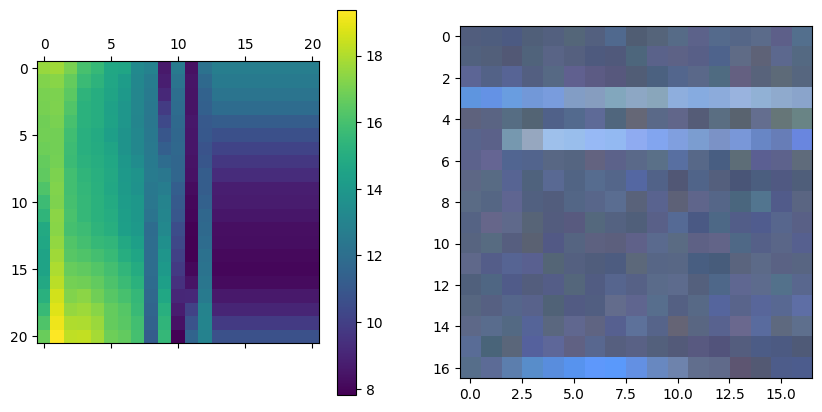

In [75]:
INDEX = 205
pixels[jnp.where(mask)[0][INDEX]]
fig,ax = plt.subplots(1,2, figsize=(10,5))

errors_for_this_window = errors[jnp.where(mask)[0][INDEX]]
fig.colorbar(ax[0].matshow(errors_for_this_window))
ax[1].imshow(windows[jnp.where(mask)[0][INDEX]])

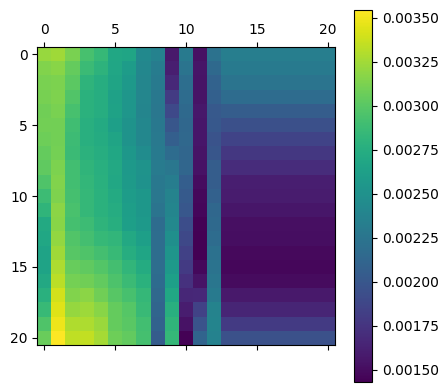

In [71]:
plt.matshow(errors_for_this_window / errors_for_this_window.sum())
plt.colorbar()